# Data preprocessing

## emotion label + path to file

In [1]:
import pandas as pd
import numpy as np
import os

path_to_data='../data/'
imgs_path='../imgs/cross_corpus/'
models_path='../models/cross_corpus/'

def load_data(path):
    emotion, file_path, database = [], [], []
    
    # iterate over audio files extracting emotion label, file path and speaker info
    for root, _, files in os.walk(path):
        if len(files): # extract info only if files are found
            for filename in files:
                if filename.split('.')[1] == 'wav':
                    temp_path_split = os.path.dirname(root).split('/')
                    # extract emotion label specific to every database
                    if temp_path_split[2] == 'emodb':
                        emotion.append(filename[5])
                    elif temp_path_split[2] == 'emovo':
                        emotion.append(filename.split('-')[0])
                    elif temp_path_split[2] == 'ravdess':
                        emotion.append(filename.split('-')[2])
                    elif temp_path_split[2] == 'tess':
                        emotion.append(filename.split('_')[2].split('.')[0])
                    elif temp_path_split[2] == 'aesdd':
                        emotion.append(os.path.basename(root))
                    elif temp_path_split[2] == 'esd':
                        emotion.append(os.path.basename(os.path.split(root)[0]))
                    file_path.append(os.path.join(root, filename))
                    database.append(temp_path_split[2])

    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = pd.concat([pd.DataFrame(file_path), pd.DataFrame(database), audio_df], axis=1)
    audio_df.columns = ['path', 'database', 'emotion']
    
    return audio_df

# fear -> anxiety, boredom -> neutral, calm -> neutral?
def translate_labels(df):
    # replace label inidication with full name for each database
    df.loc[df['database'] == 'emodb'] = df.loc[df['database'] == 'emodb'].replace({'W': 'anger', 'L': 'neutral',
                                                                               'E': 'disgust', 'A': 'anxiety',
                                                                               'F': 'happiness', 'T': 'sadness',
                                                                               'N': 'neutral'})
    df.loc[df['database'] == 'emovo'] = df.loc[df['database'] == 'emovo'].replace({'neu': 'neutral', 'dis': 'disgust',
                                                                               'gio': 'happiness','rab': 'anger',
                                                                               'sor': 'surprise', 'tri': 'sadness',
                                                                               'pau': 'anxiety'})
    df.loc[df['database'] == 'ravdess'] = df.loc[df['database'] == 'ravdess'].replace({'01': 'neutral', '02': 'calm',
                                                                                   '03': 'happiness', '04': 'sadness',
                                                                                   '05': 'anger', '06': 'anxiety',
                                                                                   '07': 'disgust', '08': 'surprise'})
    df.loc[df['database'] == 'tess'] = df.loc[df['database'] == 'tess'].replace({'sad': 'sadness', 'angry': 'anger',
                                                                                 'ps': 'surprise', 'fear': 'anxiety',
                                                                                  'happy': 'happiness', 'surprised': 'surprise'})
    df.loc[df['database'] == 'esd'] = df.loc[df['database'] == 'esd'].replace({'Happy': 'happiness', 'Angry': 'anger',
                                                                                   'Neutral': 'neutral', 'Sad': 'sadness',
                                                                                   'Surprise': 'surprise'})
    df.loc[df['database'] == 'aesdd'] = df.loc[df['database'] == 'aesdd'].replace({'fear': 'anxiety'})
    
    return df

df = load_data(path_to_data)
df = translate_labels(df)
df

,path,database,emotion
0,../data/emodb/wav/12a02Wc.wav,emodb,anger
1,../data/emodb/wav/12b09Td.wav,emodb,sadness
2,../data/emodb/wav/11b10Ae.wav,emodb,anxiety
3,../data/emodb/wav/16b03Ta.wav,emodb,sadness
4,../data/emodb/wav/09b09Ea.wav,emodb,disgust
...,...,...,...
41974,../data/aesdd/Acted Emotional Speech Dynamic D...,aesdd,anger
41975,../data/aesdd/Acted Emotional Speech Dynamic D...,aesdd,anger
41976,../data/aesdd/Acted Emotional Speech Dynamic D...,aesdd,anger
41977,../data/aesdd/Acted Emotional Speech Dynamic D...,aesdd,anger


# Plots

## class distribution

['anger' 'sadness' 'anxiety' 'disgust' 'neutral' 'happiness' 'surprise'
 'calm']


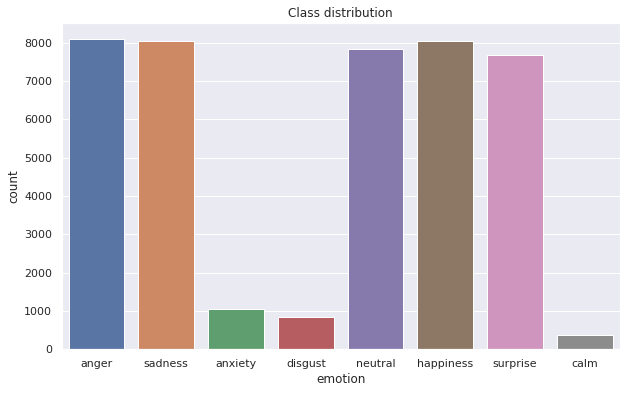

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
def class_imbalance_plot():
    print(df['emotion'].unique())
    plt.figure(figsize = (10,6))
    sns.set_theme(style='darkgrid')
    sns.countplot(x = 'emotion', data = df)
    plt.title('Class distribution')
    plt.savefig(imgs_path + 'class_distribution.png')
    plt.show()
    return

class_imbalance_plot()

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [7]:
import librosa

# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(path_to_file, _sr, _duration):
    # load file
    wavf, sample_rate = librosa.load(path_to_file, res_type="kaiser_fast", duration=_duration, sr=_sr)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 44100, 5)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,database,emotion,0,1,2,3,4,5,6,7,...,421,422,423,424,425,426,427,428,429,430
0,emodb,anger,-36.090981,-32.796627,-31.116634,-29.469265,-29.919529,-33.353619,-34.865524,-19.824419,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,emodb,sadness,-26.864872,-24.903822,-24.706491,-25.334080,-26.270023,-25.506786,-24.641876,-24.913900,...,-4.230196,-1.528415,1.268854,2.128251,2.744976,2.692754,2.974355,2.495406,1.993400,2.707010
2,emodb,anxiety,-26.956562,-27.515024,-26.380819,-25.832865,-27.194027,-26.763607,-28.808035,-27.407793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,emodb,sadness,-24.535583,-23.440098,-20.839142,-20.759388,-21.358418,-21.638031,-23.573610,-22.106657,...,-4.718640,-5.659945,-2.655658,0.158244,-0.093220,-1.432902,-3.171492,-3.927619,-1.867196,4.679281
4,emodb,disgust,-34.375870,-29.413809,-28.761814,-29.789680,-28.418623,-29.296476,-30.873238,-28.353069,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Data split

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_split(df):
    # stratified train, test split
    train, test = train_test_split(df, test_size=0.2,random_state=0, stratify=df[['emotion', 'database']])
    
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    X_train = train.iloc[:, :].drop(columns=['emotion', 'database'])
    y_train = train['emotion']
    
    X_test = test.iloc[:, :].drop(columns=['emotion', 'database'])
    y_test = test['emotion']
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

             0          1          2          3          4          5    \
7210  -38.618618 -41.710716 -48.571232 -48.688126 -47.941650 -49.145405   
30838 -26.673994 -30.784077 -39.253578 -38.053020 -38.433586 -40.798477   
34889 -42.586330 -40.835163 -39.928951 -38.346390 -39.607048 -39.602577   
10330 -33.196014 -35.687565 -38.296009 -38.674648 -37.189285 -35.932789   
3347  -36.008999 -36.711369 -35.662514 -33.637650 -34.332058 -35.239689   

             6          7          8          9    ...  421  422  423  424  \
7210  -49.233807 -49.419144 -48.916313 -48.365677  ...  0.0  0.0  0.0  0.0   
30838 -40.830948 -39.141190 -40.139446 -39.127247  ...  0.0  0.0  0.0  0.0   
34889 -41.229416 -42.615990 -40.899906 -39.494225  ...  0.0  0.0  0.0  0.0   
10330 -35.276325 -35.152790 -35.312653 -36.494091  ...  0.0  0.0  0.0  0.0   
3347  -35.195450 -36.267673 -36.942791 -34.222603  ...  0.0  0.0  0.0  0.0   

       425  426  427  428  429  430  
7210   0.0  0.0  0.0  0.0  0.0  0.0  
3083

# Data preprocessing

In [9]:
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))

    print(y_test[0:3])

    print(lb.classes_)

    # data reshaping
    X_train = X_train[:,:,np.newaxis]
    X_test = X_test[:,:,np.newaxis]

    print(X_train.shape)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

2022-04-22 11:25:54.813583: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(33583,)
(8396,)
[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
['anger' 'anxiety' 'calm' 'disgust' 'happiness' 'neutral' 'sadness'
 'surprise']
(33583, 431, 1)


# Model architecture

- [model architecture info](https://www.researchgate.net/profile/Gregor-Hofer-3/publication/335829168_Analysis_of_Deep_Learning_Architectures_for_Cross-Corpus_Speech_Emotion_Recognition/links/5e2f0a2f4585152d156d9f4f/Analysis-of-Deep-Learning-Architectures-for-Cross-Corpus-Speech-Emotion-Recognition.pdf)

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.regularizers import l2

def get_model():
    #BUILD 1D CNN LAYERS
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 422, 64)           704       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 413, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 51, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 51, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 128)           163968    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0

2022-04-22 11:25:58.616231: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-22 11:25:58.616745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-22 11:25:58.668084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 11:25:58.668279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 2.95GiB deviceMemoryBandwidth: 178.99GiB/s
2022-04-22 11:25:58.668333: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-22 11:25:58.670626: I tensorflow/stream_executor/platfor

# Model training and export

2022-04-22 11:26:04.614340: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-22 11:26:04.634901: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz
2022-04-22 11:26:05.012804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-22 11:26:05.100509: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7



Epoch 00001: val_accuracy improved from -inf to 0.36732, saving model to ../models/cross_corpus/model_1_CNN


2022-04-22 11:26:13.920664: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00002: val_accuracy improved from 0.36732 to 0.44688, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00003: val_accuracy improved from 0.44688 to 0.45152, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00004: val_accuracy improved from 0.45152 to 0.49512, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00005: val_accuracy improved from 0.49512 to 0.50905, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corpus/model_1_CNN/assets

Epoch 00006: val_accuracy improved from 0.50905 to 0.52513, saving model to ../models/cross_corpus/model_1_CNN
INFO:tensorflow:Assets written to: ../models/cross_corp

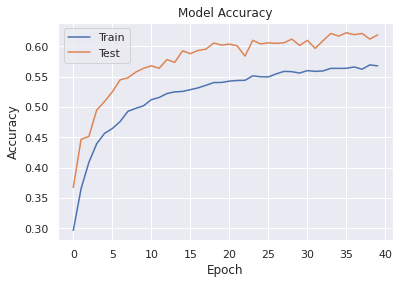

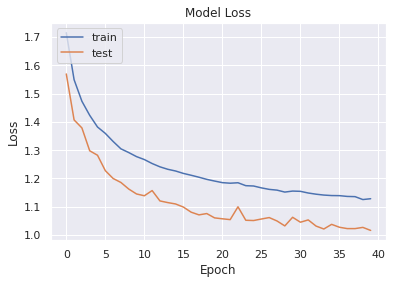

In [11]:
from keras.callbacks import ModelCheckpoint

# use checkpoints to save best model
checkpoint = ModelCheckpoint(models_path + 'model_1_CNN', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# fit model
model_history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=0)

# plot model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(imgs_path + 'Initial_Model_Accuracy.png')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(imgs_path + 'Initial_Model_loss.png')
plt.show()

# Results

## accuracy and loss

In [12]:
# loss and accuracy percentage on test set
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

263/263 [==============================] - 1s 4ms/step - loss: 1.0162 - accuracy: 0.6191
Loss of the model is -  1.0161586999893188
263/263 [==============================] - 1s 4ms/step - loss: 1.0162 - accuracy: 0.6191
Accuracy of the model is -  61.91043257713318 %


In [13]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,disgust,disgust
2,anger,anger
3,sadness,neutral
4,anger,surprise
5,happiness,neutral
6,neutral,sadness
7,surprise,anxiety
8,sadness,surprise
9,happiness,happiness


## confusion matrix

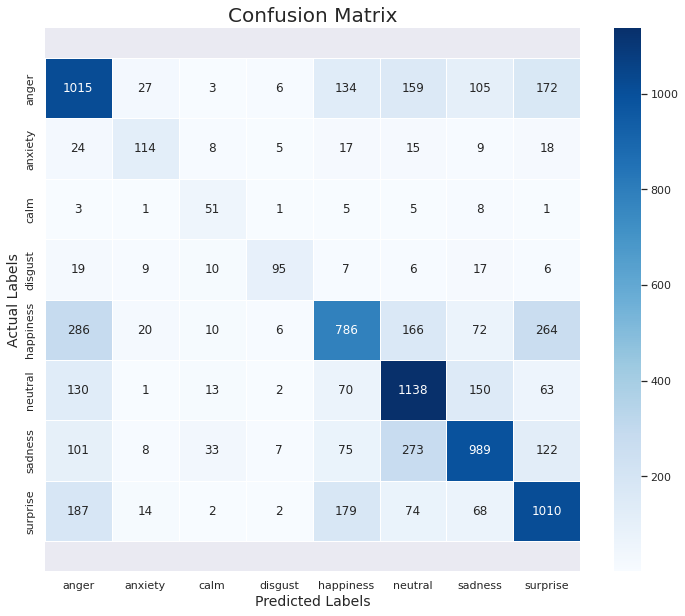

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgs_path + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [15]:
print(classification_report(actual, predictions, target_names = ['anger', 'anxiety', 'calm', 'disgust', 'happiness',
                                                                 'neutral', 'sadness', 'surprise']))

              precision    recall  f1-score   support

       anger       0.58      0.63      0.60      1621
     anxiety       0.59      0.54      0.56       210
        calm       0.39      0.68      0.50        75
     disgust       0.77      0.56      0.65       169
   happiness       0.62      0.49      0.55      1610
     neutral       0.62      0.73      0.67      1567
     sadness       0.70      0.62      0.65      1608
    surprise       0.61      0.66      0.63      1536

    accuracy                           0.62      8396
   macro avg       0.61      0.61      0.60      8396
weighted avg       0.62      0.62      0.62      8396

